In [1]:
import os
import copy
import random
import warnings
import unittest

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import torch
from torch import Tensor
import torch.nn as nn
import torch.optim as optim
from torch.optim import Optimizer
from torch.utils.data import Dataset, TensorDataset, DataLoader, WeightedRandomSampler, random_split

from PIL import Image
from torchvision import datasets
from torchvision.datasets.mnist import read_image_file, read_label_file

warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
path = "/home/kalisto/Documents/spbu_dl_2025/data/YearPredictionMSD.txt"
data = pd.read_csv(path, header=None)

y = torch.tensor(data.iloc[:, 0].values, dtype=torch.float32).view(-1, 1)
X = torch.tensor(data.iloc[:, 1:].values, dtype=torch.float32)

X_train, y_train = X[:14000], y[:14000]
X_test, y_test = X[509345:], y[509345:]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(X_train.shape, y_train.shape, X_test.shape)

torch.Size([14000, 90]) torch.Size([14000, 1]) torch.Size([6000, 90])


In [3]:
class NAdam(Optimizer):
    def __init__(self, params, lr=0.001, betas=(0.9, 0.999), eps=1e-8, schedule_decay=0.004, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, schedule_decay=schedule_decay, weight_decay=weight_decay)
        super(NAdam, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('NAdam does not support sparse gradients')
                state = self.state[p]
                if len(state) == 0:
                    state['step'] = 0
                    state['m'] = torch.zeros_like(p.data)
                    state['v'] = torch.zeros_like(p.data)
                    state['m_schedule'] = 1.0
                m, v = state['m'], state['v']
                beta1, beta2 = group['betas']
                state['step'] += 1
                t = state['step']
                m_schedule = state['m_schedule']
                m_schedule_new = m_schedule * beta1
                m_schedule_next = m_schedule_new * (1 - 0.5 * (0.96 ** (t * group['schedule_decay'])))
                m_schedule_next_next = m_schedule_next * (1 - 0.5 * (0.96 ** ((t+1) * group['schedule_decay'])))
                state['m_schedule'] = m_schedule_next
                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)
                m_t = beta1 * m + (1 - beta1) * grad
                v_t = beta2 * v + (1 - beta2) * grad * grad
                m_hat = m_t / (1 - m_schedule_next_next)
                grad_term = (beta1 * m_hat + (1 - beta1) * grad / (1 - m_schedule_next_next)) / (torch.sqrt(v_t / (1 - beta2 ** t)) + group['eps'])
                p.data.add_(grad_term, alpha=-group['lr'])
                state['m'], state['v'] = m_t, v_t
        return loss

In [4]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.numpy())
X_test_scaled = scaler.transform(X_test.numpy())

X_train_scaled = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_scaled = torch.tensor(X_test_scaled, dtype=torch.float32)

y_train_tensor = y_train.clone().detach()
y_test_tensor = y_test.clone().detach()

if y_train_tensor.dtype != torch.float32:
    y_train_tensor = y_train_tensor.float()
if y_test_tensor.dtype != torch.float32:
    y_test_tensor = y_test_tensor.float()
if y_train_tensor.dim() == 1:
    y_train_tensor = y_train_tensor.unsqueeze(1)
if y_test_tensor.dim() == 1:
    y_test_tensor = y_test_tensor.unsqueeze(1)
    
X_train_scaled = X_train_scaled.to(device)
X_test_scaled = X_test_scaled.to(device)

y_train_tensor = y_train_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

In [5]:
class NeuralNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.Dropout(0.2),
            nn.Sigmoid(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 128),
            nn.Dropout(0.2),
            nn.Sigmoid(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 512),
            nn.Dropout(0.2),
            nn.Sigmoid(),
            nn.BatchNorm1d(512),
            nn.Linear(512, 128)
        )
    def forward(self, x):
        return self.network(x)



In [6]:
model = NeuralNet(X_train.shape[1])
model = model.to(device)
criterion = nn.MSELoss()
optimizer = NAdam(model.parameters(), lr=0.0025)

dataset = TensorDataset(X_train_scaled, y_train_tensor)
val_ratio = 0.2
val_size = int(len(dataset) * val_ratio)
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

y_train_np = y_train_tensor.cpu().numpy().ravel()
unique, counts = np.unique(y_train_np, return_counts=True)
use_sampler = False
sampler = None
if unique.shape[0] <= 2 and np.issubdtype(y_train_np.dtype, np.integer) or unique.shape[0] <= 10:
    sample_counts = {}
    for u, c in zip(unique, counts):
        sample_counts[u] = c
    weights = np.array([1.0 / sample_counts[float(y)] for y in y_train_np], dtype=np.float32)
    weights_tensor = torch.from_numpy(weights)
    indices = train_dataset.indices if hasattr(train_dataset, 'indices') else list(range(train_size))
    weights_for_train = weights_tensor[indices]
    sampler = WeightedRandomSampler(weights_for_train, num_samples=len(weights_for_train), replacement=True)
    use_sampler = True

batch_size = 512

if use_sampler:
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
else:
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [7]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.best_state = None
    def step(self, loss, model):
        if self.best_loss is None or loss < self.best_loss - self.min_delta:
            self.best_loss = loss
            self.counter = 0
            self.best_state = copy.deepcopy(model.state_dict())
            return False
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
            return False

Epoch 1/200, Loss: 147922.6593
Epoch 2/200, Loss: 147467.9416
Epoch 3/200, Loss: 146038.0450
Epoch 4/200, Loss: 143397.4896
Epoch 5/200, Loss: 139516.2178
Epoch 6/200, Loss: 134453.7087
Epoch 7/200, Loss: 128315.5913
Epoch 8/200, Loss: 121237.5226
Epoch 9/200, Loss: 113375.0671
Epoch 10/200, Loss: 104899.0875
Epoch 11/200, Loss: 95989.4999
Epoch 12/200, Loss: 86829.7061
Epoch 13/200, Loss: 77602.9573
Epoch 14/200, Loss: 68484.7707
Epoch 15/200, Loss: 59639.8311
Epoch 16/200, Loss: 51215.3658
Epoch 17/200, Loss: 43337.7366
Epoch 18/200, Loss: 36107.3334
Epoch 19/200, Loss: 29597.2783
Epoch 20/200, Loss: 23850.6572
Epoch 21/200, Loss: 18880.7875
Epoch 22/200, Loss: 14672.7372
Epoch 23/200, Loss: 11187.4023
Epoch 24/200, Loss: 8365.1326
Epoch 25/200, Loss: 6132.4991
Epoch 26/200, Loss: 4406.8420
Epoch 27/200, Loss: 3104.5041
Epoch 28/200, Loss: 2144.6393
Epoch 29/200, Loss: 1453.4239
Epoch 30/200, Loss: 966.9031
Epoch 31/200, Loss: 632.0680
Epoch 32/200, Loss: 406.3871
Epoch 33/200, Loss:

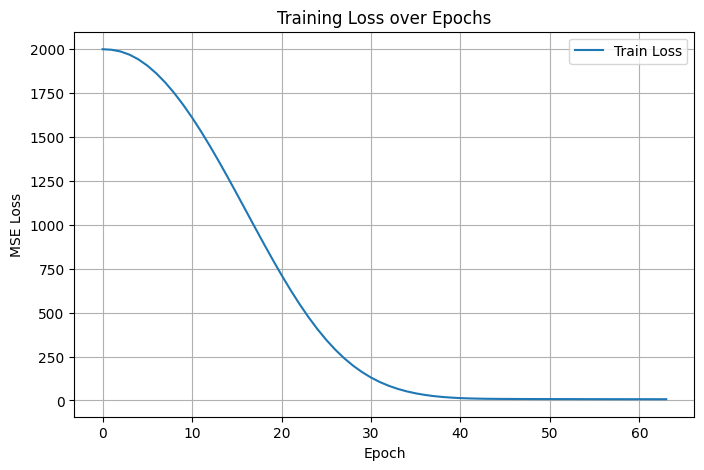

In [8]:
early_stopper = EarlyStopping(patience=6, min_delta=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

epochs = 200
train_losses = []
val_losses = []
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_X.size(0)
    epoch_loss = epoch_loss / train_size
    train_losses.append(epoch_loss)
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for vX, vy in val_loader:
            vout = model(vX)
            vloss = criterion(vout, vy)
            val_loss += vloss.item() * vX.size(0)
    val_loss = val_loss / val_size
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/(X_train_scaled.size()[0]//batch_size):.4f}")
    scheduler.step(val_loss)
    if early_stopper.step(val_loss, model):
        break

if early_stopper.best_state is not None:
    model.load_state_dict(early_stopper.best_state)

model.eval()
with torch.no_grad():
    y_pred = model(X_test_scaled)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f"Test MSE: {test_loss.item():.4f}")
    pred_year = torch.round(y_pred)
pred_year = torch.round(y_pred)

plt.figure(figsize=(8,5))
plt.plot(np.sqrt(train_losses), label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Задание 2. Свертки и базовые слои 
Это задание будет являться духовным наследником первого. 
Вы уже научились делать шаги градиентного спуска и вспомнили, как устроен базовый линейный слой.
На этой неделе мы построим прототип базового фреймворка до конца (собственно, многое вы сможете скопировать, если захотите). 
Хоть вы уже и знаете о torch.nn, для выполнения задания его использовать нельзя. 
Однако все элементы, которые вы будете реализовывать, достаточно просты.

### Задача 1. (2 балла)
#### Реализуйте слой BatchNorm (nn.BatchNorm). 

In [9]:
class BatchNorm1d:
    def __init__(self, features: int, eps=1e-6, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.gamma = torch.ones(features)
        self.beta = torch.zeros(features)
        self.running_mean = torch.zeros(features)
        self.running_var = torch.ones(features)
        self.training = True
        
    def forward(self, x: Tensor) -> Tensor:
        if self.training:
            mean = x.mean(0)
            var = x.var(0, unbiased = False) #unbiased=False для вычисления точной дисперсии батча
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * var
        else: 
            mean = self.running_mean
            var = self.running_var
        return self.gamma * (x-mean) / torch.sqrt(var+self.eps) + self.beta
    
x_example = torch.randn(4,4)
print(x_example)
print(BatchNorm1d(4).forward(x_example))

tensor([[ 1.0112,  0.6000,  0.9893, -0.7022],
        [ 1.2427, -0.0586,  0.2398,  0.0429],
        [-1.0446, -0.7482,  2.0591, -0.4140],
        [-0.1471, -0.7362, -1.1399,  0.8755]])
tensor([[ 0.8090,  1.4993,  0.3884, -1.0944],
        [ 1.0603,  0.3178, -0.2553,  0.1548],
        [-1.4215, -0.9193,  1.3073, -0.6111],
        [-0.4478, -0.8978, -1.4404,  1.5507]])


In [10]:
class TestBatchNorm1d(unittest.TestCase):
    def test_shape(self):
        x = torch.randn(16,8)
        y = BatchNorm1d(8).forward(x)
        self.assertEqual(y.shape, x.shape)
        
    def test_mean_var(self):
        x = torch.randn(16,8)
        y = BatchNorm1d(8).forward(x)
        mean = y.mean(0)
        var = y.var(0, unbiased=False)
        self.assertTrue(torch.allclose(mean, torch.zeros_like(mean), atol=1e-1))
        self.assertTrue(torch.allclose(var, torch.ones_like(var), atol=1e-1))

if __name__ == "__main__":        
    unittest.main(argv=[""], exit=False)

..
----------------------------------------------------------------------
Ran 2 tests in 0.001s

OK


### Задача 2. (2 балла)
#### Реализуйте слой Linear (nn.Linear). 

In [11]:
class Linear:
    def __init__(self, in_features: int, out_features: int):
        self.weight = torch.randn(out_features, in_features) * 0.01
        self.bias = torch.zeros(out_features)
        
    def forward(self, x: Tensor) -> Tensor:
        return x @ self.weight.t() + self.bias
    
x_example = torch.randn(8, 4)
print(x_example)
print(Linear(4,1).forward(x_example))

tensor([[-0.8677, -0.5801,  0.5791, -0.1216],
        [ 2.0006,  0.6690, -1.9043, -0.4570],
        [ 0.5941,  1.0390,  1.3834,  0.0435],
        [-1.3621, -0.2594, -0.1106,  1.3243],
        [-0.2793, -3.1053, -0.4177, -0.9200],
        [ 1.1854,  1.3117, -0.4880, -0.8367],
        [-0.8858,  1.3336, -0.1651, -0.2705],
        [-1.5453, -1.9192, -1.7784,  0.9205]])
tensor([[-0.0154],
        [ 0.0219],
        [ 0.0124],
        [ 0.0005],
        [-0.0196],
        [ 0.0035],
        [-0.0209],
        [-0.0115]])


In [12]:
class TestBatchNorm1d(unittest.TestCase):
    def test_shape(self):
        x = torch.randn(16,8)
        y = Linear(8,4).forward(x)
        self.assertEqual(y.shape[0], x.shape[0])
        self.assertEqual(y.shape[1], int(x.shape[1]/2))
        
if __name__ == "__main__":        
    unittest.main(argv=[""], exit=False)

.
----------------------------------------------------------------------
Ran 1 test in 0.000s

OK


### Задача 3. (2 балла)
#### Реализуйте слой Dropout(nn.Dropout)

In [13]:
class Dropout:
    def __init__(self, p: int):
        self.p = p
        self.training = True
        
    def forward(self, x: Tensor) -> Tensor:
        if not self.training or self.p == 0:
            return X
        mask = (torch.rand_like(x) > self.p).float()
        return x * mask / (1 - self.p)
    
x_example = torch.randn(8, 4)
print(x_example)
print(Dropout(0.8).forward(x_example))

tensor([[ 0.5019, -0.9009,  0.1384,  1.1963],
        [-0.6626,  0.7391, -1.6307,  0.5721],
        [-0.8374,  2.3879,  1.0321,  1.3582],
        [ 0.7166, -1.2175,  0.6338, -0.4196],
        [ 0.3034,  1.6850, -1.6079, -0.6286],
        [ 0.2352,  0.2096,  0.8874, -1.1355],
        [-1.3268,  0.5717,  0.0909,  0.5022],
        [-0.5257, -0.6629, -1.7505,  0.8383]])
tensor([[ 0.0000, -0.0000,  0.6919,  5.9817],
        [-0.0000,  0.0000, -0.0000,  2.8605],
        [-0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000, -6.0873,  3.1691, -0.0000],
        [ 0.0000,  0.0000, -0.0000, -3.1431],
        [ 0.0000,  0.0000,  0.0000, -0.0000],
        [-6.6342,  0.0000,  0.4546,  2.5110],
        [-2.6284, -0.0000, -8.7525,  0.0000]])


In [14]:
class TestDropout(unittest.TestCase):
    def test_shape(self):
        x = torch.randn(16,8)
        y = Dropout(0.8).forward(x)
        self.assertEqual(y.shape, x.shape)
    
    def test_dropout(self):
        x = torch.randn(16, 8)
        p = 0.5
        y = Dropout(p).forward(x)
        total = x.numel()
        num_zeros = (y == 0).sum().item()
        expected = total * p
        self.assertTrue(abs(num_zeros - expected) / total < 0.2)
        
if __name__ == "__main__":        
    unittest.main(argv=[""], exit=False)

...
----------------------------------------------------------------------
Ran 3 tests in 0.002s

OK


### Задача 4. {*} (2 балла, 1 за каждый следующий за слой)
#### Реализуйте одно или более из:
  - слой ReLU(nn.ReLU)
  - слой Sigmoid(nn.Sigmoid)
  - слой Softmax(nn.Softmax)

**1. Sigmoid:**

$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$


**2. ReLU:**

$$
\text{ReLU}(x) = \max(0, x)
$$

**3. Softmax:**

$$
\text{Softmax}(x_i) = \frac{e^{x_i}}{\sum_{j=1}^{n} e^{x_j}}
$$


In [15]:
class ReLU:
    @staticmethod
    def forward(x: Tensor) -> Tensor:
        return torch.maximum(torch.tensor(0.0), x)
    
class Sigmoid:
    @staticmethod
    def forward(x: Tensor) -> Tensor:
        return torch.sigmoid(x)
        #return 1 / (1 + torch.exp(-x))
    
class Softmax:
    @staticmethod
    def forward(x: Tensor) -> Tensor:
        return torch.softmax(x, dim=1)
        #x_exp = torch.exp(x - x.max(dim=1, keepdim=True).values)
        #return x_exp / x_exp.sum(dim=1, keepdim=True)
    
x_example = torch.randn(4, 2)
print(x_example)
print(ReLU.forward(x_example))
print(Sigmoid.forward(x_example))
print(Softmax.forward(x_example))

tensor([[-0.1170, -0.2808],
        [ 1.5226,  0.7037],
        [-0.6867, -0.1429],
        [ 0.0409,  0.8758]])
tensor([[0.0000, 0.0000],
        [1.5226, 0.7037],
        [0.0000, 0.0000],
        [0.0409, 0.8758]])
tensor([[0.4708, 0.4302],
        [0.8209, 0.6690],
        [0.3348, 0.4643],
        [0.5102, 0.7059]])
tensor([[0.5409, 0.4591],
        [0.6940, 0.3060],
        [0.3673, 0.6327],
        [0.3026, 0.6974]])


In [16]:
class SigmoidNative: #σ(x)=1+e−x1​
    @staticmethod
    def forward(x: Tensor) -> Tensor:
        #return torch.sigmoid(x)
        return 1 / (1 + torch.exp(-x))
    
class SoftmaxNative: #σ(x)=1+e−x1​
    @staticmethod
    def forward(x: Tensor) -> Tensor:
        #return torch.softmax(x, dim=1)
        x_exp = torch.exp(x - x.max(dim=1, keepdim=True).values)
        return x_exp / x_exp.sum(dim=1, keepdim=True)

In [17]:
class TestReLU(unittest.TestCase):
    def test_shape(self):
        x = torch.randn(16,8)
        y = ReLU.forward(x)
        self.assertEqual(y.shape, x.shape)
    
    def test_positive(self):
        x = torch.randn(16, 8)
        y = ReLU.forward(x)
        self.assertTrue((y >= 0).all())
        
class TestSigmoid(unittest.TestCase):
    def test_shape(self):
        x = torch.randn(16,8)
        y = Sigmoid.forward(x)
        y_native = SigmoidNative.forward(x)
        self.assertEqual(y.shape, x.shape)
        self.assertEqual(y_native.shape, x.shape)
    
    def test_sigmoid(self):
        x = torch.randn(16, 8)
        y = Sigmoid.forward(x)
        y_native = SigmoidNative.forward(x)
        self.assertTrue(torch.allclose(y, y_native, atol=1e-6))

class TestSoftmax(unittest.TestCase):
    def test_shape(self):
        x = torch.randn(16,8)
        y = Softmax.forward(x)
        y_native = SoftmaxNative.forward(x)
        self.assertEqual(y.shape, x.shape)
        self.assertEqual(y_native.shape, x.shape)
    
    def test_softmax(self):
        x = torch.randn(16, 8)
        y = Softmax.forward(x)
        y_native = SoftmaxNative.forward(x)
        self.assertTrue(torch.allclose(y, y_native, atol=1e-6))
        
if __name__ == "__main__":        
    unittest.main(argv=[""], exit=False)

.........
----------------------------------------------------------------------
Ran 9 tests in 0.003s

OK


### Задача 5. {*}. 
#### Вы получите по 1 дополнительному баллу за слой, если реализуете в рамках фреймворка из задания 3 прошлой работы

In [18]:
class Custom_Linear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(out_features, in_features) * 0.01)
        self.bias = nn.Parameter(torch.zeros(out_features))

    def forward(self, x):
        return x @ self.weight.t() + self.bias

class Custom_Dropout(nn.Module):
    def __init__(self, p: float):
        super().__init__()
        self.p = p

    def forward(self, x: Tensor) -> Tensor:
        if not self.training or self.p == 0:
            return x
        mask = (torch.rand_like(x) > self.p).float()
        return x * mask / (1 - self.p)
    
class Custom_ReLU(nn.Module):
    def forward(self, x: Tensor) -> Tensor:
        return torch.maximum(torch.tensor(0.0), x)
    
class Custom_Sigmoid(nn.Module):
    def forward(self, x: Tensor) -> Tensor:
        return torch.sigmoid(x)

class Custom_Softmax(nn.Module):
    def forward(self, x: Tensor) -> Tensor:
        return torch.softmax(x, dim=1)
        
class Custom_BatchNorm1d(nn.Module):
    def __init__(self, features, eps=1e-6, momentum=0.1):
        super().__init__()
        self.eps = eps
        self.momentum = momentum
        self.gamma = nn.Parameter(torch.ones(features))
        self.beta = nn.Parameter(torch.zeros(features))
        self.register_buffer('running_mean', torch.zeros(features))
        self.register_buffer('running_var', torch.ones(features))

    def forward(self, x):
        if self.training:
            mean = x.mean(0)
            var = x.var(0, unbiased=False)
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * var
        else:
            mean = self.running_mean
            var = self.running_var
        return self.gamma * (x - mean) / torch.sqrt(var + self.eps) + self.beta


In [19]:
class NeuralNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.network = nn.Sequential(
            Custom_Linear(input_dim, 256),
            Custom_Dropout(0.2),
            Custom_ReLU(),
            Custom_BatchNorm1d(256),
            Custom_Linear(256, 128),
            Custom_Dropout(0.2),
            Custom_Sigmoid(),
            Custom_BatchNorm1d(128),
            Custom_Linear(128, 512),
            Custom_Dropout(0.2),
            Custom_Softmax(),
            Custom_BatchNorm1d(512),
            Custom_Linear(512, 128)
        )
    def forward(self, x):
        return self.network(x)

In [20]:
model = NeuralNet(X_train.shape[1])
model = model.to(device)
criterion = nn.MSELoss()
optimizer = NAdam(model.parameters(), lr=0.0025)

dataset = TensorDataset(X_train_scaled, y_train_tensor)
val_ratio = 0.2
val_size = int(len(dataset) * val_ratio)
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

y_train_np = y_train_tensor.cpu().numpy().ravel()
unique, counts = np.unique(y_train_np, return_counts=True)
use_sampler = False
sampler = None
if unique.shape[0] <= 2 and np.issubdtype(y_train_np.dtype, np.integer) or unique.shape[0] <= 10:
    sample_counts = {}
    for u, c in zip(unique, counts):
        sample_counts[u] = c
    weights = np.array([1.0 / sample_counts[float(y)] for y in y_train_np], dtype=np.float32)
    weights_tensor = torch.from_numpy(weights)
    indices = train_dataset.indices if hasattr(train_dataset, 'indices') else list(range(train_size))
    weights_for_train = weights_tensor[indices]
    sampler = WeightedRandomSampler(weights_for_train, num_samples=len(weights_for_train), replacement=True)
    use_sampler = True

batch_size = 512

if use_sampler:
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
else:
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Epoch 1/200, Loss: 147920.9149
Epoch 2/200, Loss: 147472.9438
Epoch 3/200, Loss: 146048.7799
Epoch 4/200, Loss: 143411.2574
Epoch 5/200, Loss: 139530.6119
Epoch 6/200, Loss: 134467.0047
Epoch 7/200, Loss: 128327.0964
Epoch 8/200, Loss: 121246.7768
Epoch 9/200, Loss: 113381.4666
Epoch 10/200, Loss: 104902.6799
Epoch 11/200, Loss: 95990.5766
Epoch 12/200, Loss: 86828.1876
Epoch 13/200, Loss: 77599.0645
Epoch 14/200, Loss: 68478.7930
Epoch 15/200, Loss: 59632.2147
Epoch 16/200, Loss: 51206.6039
Epoch 17/200, Loss: 43327.9384
Epoch 18/200, Loss: 36097.1691
Epoch 19/200, Loss: 29586.8228
Epoch 20/200, Loss: 23839.9865
Epoch 21/200, Loss: 18870.2472
Epoch 22/200, Loss: 14662.8307
Epoch 23/200, Loss: 11178.0051
Epoch 24/200, Loss: 8356.8312
Epoch 25/200, Loss: 6125.0070
Epoch 26/200, Loss: 4400.0850
Epoch 27/200, Loss: 3098.2797
Epoch 28/200, Loss: 2138.9758
Epoch 29/200, Loss: 1448.3044
Epoch 30/200, Loss: 962.2212
Epoch 31/200, Loss: 627.8518
Epoch 32/200, Loss: 402.4931
Epoch 33/200, Loss:

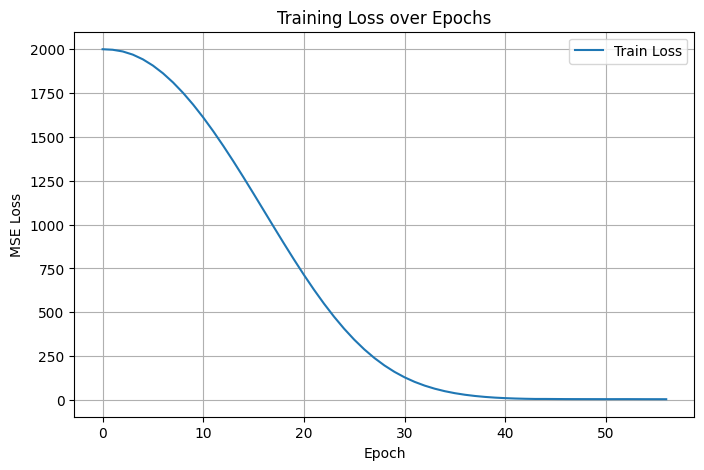

In [21]:
early_stopper = EarlyStopping(patience=6, min_delta=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

epochs = 200
train_losses = []
val_losses = []
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_X.size(0)
    epoch_loss = epoch_loss / train_size
    train_losses.append(epoch_loss)
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for vX, vy in val_loader:
            vout = model(vX)
            vloss = criterion(vout, vy)
            val_loss += vloss.item() * vX.size(0)
    val_loss = val_loss / val_size
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/(X_train_scaled.size()[0]//batch_size):.4f}")
    scheduler.step(val_loss)
    if early_stopper.step(val_loss, model):
        break

if early_stopper.best_state is not None:
    model.load_state_dict(early_stopper.best_state)

model.eval()
with torch.no_grad():
    y_pred = model(X_test_scaled)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f"Test MSE: {test_loss.item():.4f}")
    pred_year = torch.round(y_pred)
pred_year = torch.round(y_pred)

plt.figure(figsize=(8,5))
plt.plot(np.sqrt(train_losses), label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

### Задание 2. {*} 3 балла
- Реализуйте медианный фильтр. 
- Для текущего пикселя, пиксели, которые «попадают» в матрицу, 
- сортируются, и выбирается медианное значение из отсортированного массива. 
- Это значение и является выходным для текущего пикселя.
- Используйте только чистый torch. Покажите результат на примере для размера ядра 3, 5, 10

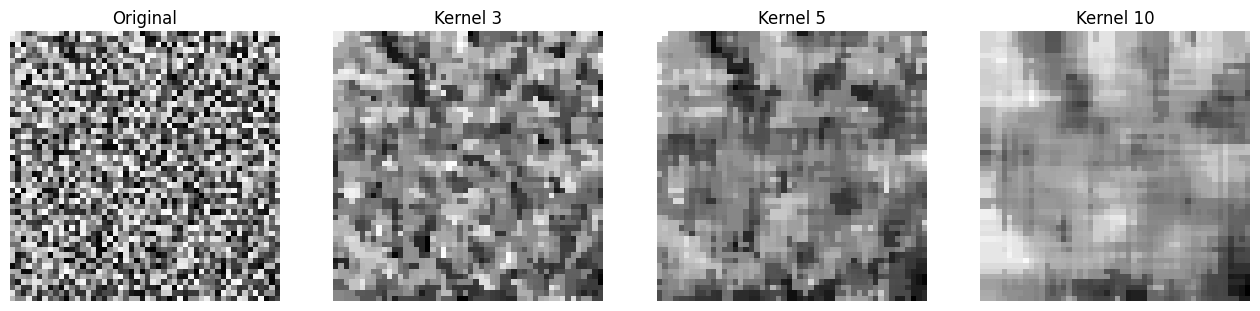

In [22]:
def reflect_pad(img: Tensor, pad: int) -> Tensor:
    H, W = img.shape
    padded = torch.empty((H + 2*pad, W + 2*pad), dtype=img.dtype)
    padded[pad:pad+H, pad:pad+W] = img
    # Верх
    for i in range(pad):
        padded[i, pad:pad+W] = img[pad-i, :]
    # Низ
    for i in range(pad):
        padded[H+pad+i, pad:pad+W] = img[H-2-i, :]
    # Лево и право
    for i in range(H + 2*pad):
        for j in range(pad):
            padded[i, j] = padded[i, 2*pad-j]
            padded[i, W+pad+j] = padded[i, W+pad-2-j]
            
    return padded

def median_filter(img: Tensor, kernel_size: int) -> Tensor:
    pad = kernel_size // 2
    img_padded = reflect_pad(img, pad)
    H, W = img.shape
    filtered = torch.empty_like(img, dtype=torch.float32)
    for i in range(H):
        for j in range(W):
            window = img_padded[i:i+kernel_size, j:j+kernel_size]
            filtered[i, j] = window.flatten().median()
    return filtered
img = torch.randint(0, 256, (50, 50), dtype=torch.uint8)

filtered_3 = median_filter(img, 3)
filtered_5 = median_filter(img, 5)
filtered_10 = median_filter(img, 10)

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
axes[0].imshow(img, cmap='gray')
axes[0].set_title("Original")
axes[1].imshow(filtered_3, cmap='gray')
axes[1].set_title("Kernel 3")
axes[2].imshow(filtered_5, cmap='gray')
axes[2].set_title("Kernel 5")
axes[3].imshow(filtered_10, cmap='gray')
axes[3].set_title("Kernel 10")
for ax in axes:
    ax.axis('off')
plt.show()


### Задание 3. 6 баллов
#### Реализуйте следующие классы (указана сигнатура __init__):
- BaseTransform(p: float) [*базовый класс для всех трансформаций*]
- RandomCrop(p: float, **kwargs)
- RandomRotate(p: float, **kwargs)
- RandomZoom(p: float, **kwargs) {*}
- ToTensor() 
- Compose(list[BaseTransform])

In [23]:
class BaseTransform:
    def __init__(self, p: float):
        self.p = p

    def __call__(self, img):
        if random.random() < self.p:
            return self.apply(img)
        return img

    def apply(self, img):
        raise NotImplementedError

class RandomCrop(BaseTransform):
    def __init__(self, p: float, size: tuple):
        super().__init__(p)
        self.size = size

    def apply(self, img):
        width, height = img.size
        crop_width, crop_height = self.size
        if crop_width > width or crop_height > height:
            return img
        left = random.randint(0, width - crop_width)
        top = random.randint(0, height - crop_height)
        return img.crop((left, top, left + crop_width, top + crop_height))

class RandomRotate(BaseTransform):
    def __init__(self, p: float, degrees: int):
        super().__init__(p)
        self.degrees = degrees

    def apply(self, img):
        angle = random.uniform(-self.degrees, self.degrees)
        return img.rotate(angle)

class RandomZoom(BaseTransform):
    def __init__(self, p: float, zoom_range: tuple):
        super().__init__(p)
        self.zoom_range = zoom_range

    def apply(self, img):
        width, height = img.size
        zoom = random.uniform(*self.zoom_range)
        new_width = int(width * zoom)
        new_height = int(height * zoom)
        img = img.resize((new_width, new_height), Image.BILINEAR)
        left = max(0, (new_width - width) // 2)
        top = max(0, (new_height - height) // 2)
        return img.crop((left, top, left + width, top + height))

class ToTensor:
    def __call__(self, img):
        arr = np.array(img, dtype=np.float32)
        if arr.ndim == 2:
            arr = arr[:, :, None]
        arr = arr.transpose((2, 0, 1))
        arr /= 255.0
        return torch.tensor(arr, dtype=torch.float32)

class Compose:
    def __init__(self, transforms_list):
        self.transforms = transforms_list

    def __call__(self, img):
        for t in self.transforms:
            img = t(img)
        return img

class FixedSize:
    def __init__(self, size):
        self.size = size
    def __call__(self, img):
        return img.resize(self.size, Image.BILINEAR)



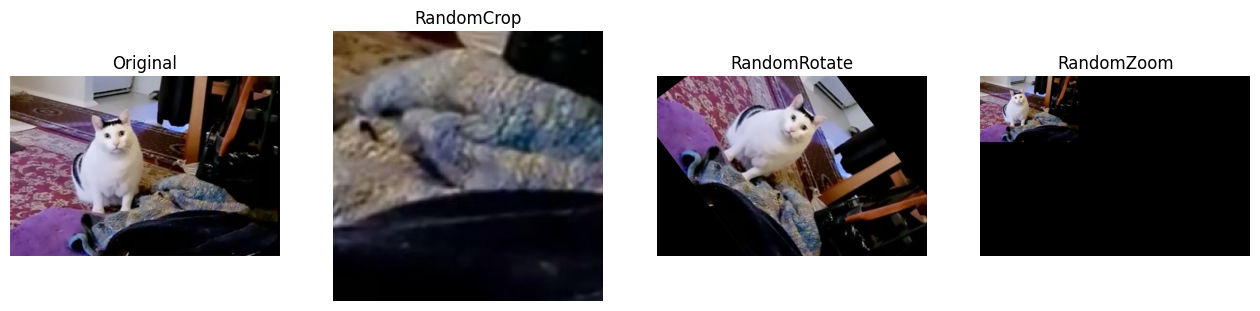

In [24]:
img = Image.open("/home/kalisto/Documents/spbu_dl_2025/images/kot_mjaukaet.jpg")

crop = RandomCrop(p=1.0, size=(200, 200))
rotate = RandomRotate(p=1.0, degrees=90)
zoom = RandomZoom(p=1.0, zoom_range=(0.2, 5))
to_tensor = ToTensor()

img_crop = crop(img)
img_rotate = rotate(img)
img_zoom = zoom(img)
img_tensor = to_tensor(img) 

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
axes[0].imshow(img)
axes[0].set_title("Original")
axes[1].imshow(img_crop)
axes[1].set_title("RandomCrop")
axes[2].imshow(img_rotate)
axes[2].set_title("RandomRotate")
axes[3].imshow(img_zoom)
axes[3].set_title("RandomZoom")
for ax in axes:
    ax.axis('off')
plt.show()


In [25]:
class TestTransforms(unittest.TestCase):
    def setUp(self):
        random.seed(42)
        np.random.seed(42)
        torch.manual_seed(42)
        self.img = Image.fromarray(np.arange(100*100*3, dtype=np.uint8).reshape(100, 100, 3))

    def test_random_crop_reproducibility(self):
        crop = RandomCrop(p=1.0, size=(50, 50))
        random.seed(42)
        result1 = crop(self.img)
        random.seed(42)
        result2 = crop(self.img)
        self.assertEqual(result1.tobytes(), result2.tobytes())

    def test_random_crop_boundary(self):
        crop_large = RandomCrop(p=1.0, size=(200, 200))
        result = crop_large(self.img)
        self.assertEqual(result.size, self.img.size)

    def test_random_rotate_reproducibility(self):
        rotate = RandomRotate(p=1.0, degrees=45)
        random.seed(42)
        result1 = rotate(self.img)
        random.seed(42)
        result2 = rotate(self.img)
        self.assertEqual(result1.tobytes(), result2.tobytes())

    def test_random_zoom_reproducibility(self):
        zoom = RandomZoom(p=1.0, zoom_range=(0.5, 2.0))
        random.seed(42)
        result1 = zoom(self.img)
        random.seed(42)
        result2 = zoom(self.img)
        self.assertEqual(result1.tobytes(), result2.tobytes())

    def test_random_zoom_boundary(self):
        zoom_fixed = RandomZoom(p=1.0, zoom_range=(1.0, 1.0))
        result = zoom_fixed(self.img)
        self.assertEqual(result.size, self.img.size)

    def test_to_tensor(self):
        to_tensor = ToTensor()
        tensor_result = to_tensor(self.img)
        self.assertIsInstance(tensor_result, torch.Tensor)
        self.assertEqual(tensor_result.shape, (3, 100, 100))
        self.assertTrue(torch.all((tensor_result >= 0) & (tensor_result <= 1)))

    def test_compose_reproducibility(self):
        compose = Compose([
            RandomCrop(p=1.0, size=(50, 50)),
            RandomRotate(p=1.0, degrees=30),
            RandomZoom(p=1.0, zoom_range=(0.5, 1.5))
        ])
        random.seed(42)
        result1 = compose(self.img)
        random.seed(42)
        result2 = compose(self.img)
        self.assertEqual(result1.tobytes(), result2.tobytes())

if __name__ == "__main__":
    unittest.main(argv=[""], exit=False)


................
----------------------------------------------------------------------
Ran 16 tests in 0.011s

OK


### Задание 4. 3 балла
- Примените трансформации из задания 3 в качестве трансформаций датасета из практики 2.2.
- **В этом задании можно пользоваться torch.nn, за исключением трансформаций.**
- Покажите, как меняются лосс и метрики на трейне и на тесте в зависимости от количества и вероятностей трансформаций.
- Проведите обучение на большом количестве эпох. 
- Опишите, что вы наблюдаете для каждого случая и какая есть разница,
- если применить трансформации.
- Предоставьте графики в matplotlib или tensorboard (+1 балл) в 
- ноутбуке (в случае с tensorboard можно в отдельном окне) с наглядными примерами

no_aug Epoch 1: Train 0.4821/0.8205, Test 0.4041/0.8537
no_aug Epoch 2: Train 0.3445/0.8718, Test 0.3552/0.8728
no_aug Epoch 3: Train 0.3165/0.8814, Test 0.3763/0.8640
no_aug Epoch 4: Train 0.3048/0.8853, Test 0.3447/0.8810
no_aug Epoch 5: Train 0.2985/0.8890, Test 0.3638/0.8674
no_aug Epoch 6: Train 0.2843/0.8942, Test 0.3447/0.8823
no_aug Epoch 7: Train 0.2860/0.8929, Test 0.3317/0.8800
no_aug Epoch 8: Train 0.2737/0.8973, Test 0.3544/0.8771
no_aug Epoch 9: Train 0.2699/0.8997, Test 0.3373/0.8812
no_aug Epoch 10: Train 0.2652/0.9003, Test 0.3510/0.8830
crop Epoch 1: Train 0.4776/0.8232, Test 0.3833/0.8560
crop Epoch 2: Train 0.3483/0.8684, Test 0.3800/0.8661
crop Epoch 3: Train 0.3277/0.8764, Test 0.3432/0.8758
crop Epoch 4: Train 0.3154/0.8809, Test 0.3606/0.8714
crop Epoch 5: Train 0.3089/0.8833, Test 0.3509/0.8738
crop Epoch 6: Train 0.2977/0.8882, Test 0.3407/0.8748
crop Epoch 7: Train 0.2964/0.8882, Test 0.3421/0.8769
crop Epoch 8: Train 0.2881/0.8910, Test 0.3509/0.8744
crop Ep

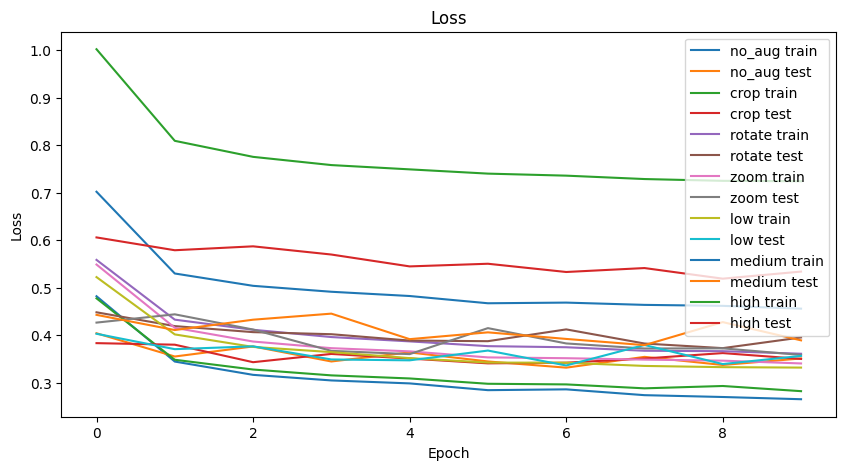

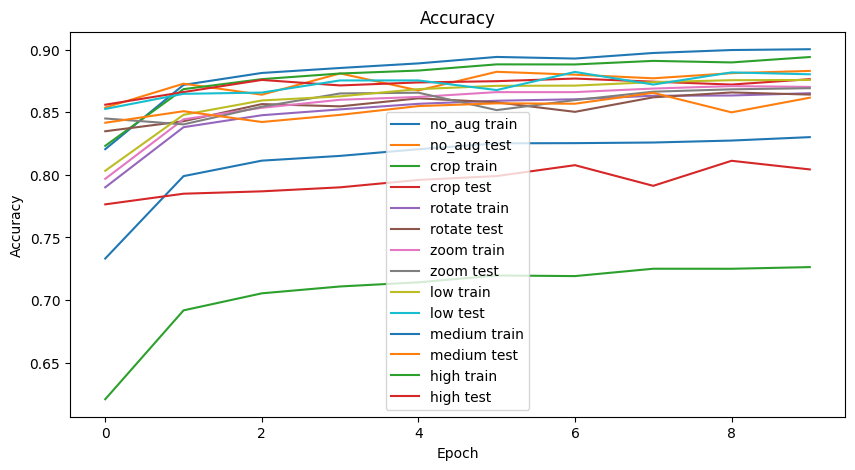

In [26]:
# Настройки
batch_size = 64
epochs = 10
learning_rate = 0.01

# Трансформации
transform_no_aug = Compose([ToTensor()])

transform_aug_crop = Compose([RandomCrop(0.3, (28,28)), FixedSize((28,28)), ToTensor()])
transform_aug_rotate = Compose([RandomRotate(0.3,15), FixedSize((28,28)), ToTensor()])
transform_aug_zoom = Compose([RandomZoom(0.7,(0.9,1.1)), FixedSize((28,28)), ToTensor()])

transform_aug_low = Compose([RandomCrop(0.3,(28,28)), RandomRotate(0.3,15), RandomZoom(0.3,(0.9,1.1)), FixedSize((28,28)), ToTensor()])
transform_aug_medium = Compose([RandomCrop(0.5,(28,28)), RandomRotate(0.5,30), RandomZoom(0.5,(0.7,1.4)), FixedSize((28,28)), ToTensor()])
transform_aug_high = Compose([RandomCrop(0.7,(28,28)), RandomRotate(0.7,45), RandomZoom(0.7,(0.5,2)), FixedSize((28,28)), ToTensor()])

# Датасеты и загрузчики
train_loaders = {
    "no_aug": DataLoader(datasets.FashionMNIST(root="/home/kalisto/Documents/spbu_dl_2025/data", train=True, download=True, transform=transform_no_aug), batch_size=batch_size, shuffle=True),
    "crop": DataLoader(datasets.FashionMNIST(root="/home/kalisto/Documents/spbu_dl_2025/data", train=True, download=True, transform=transform_aug_crop), batch_size=batch_size, shuffle=True),
    "rotate": DataLoader(datasets.FashionMNIST(root="/home/kalisto/Documents/spbu_dl_2025/data", train=True, download=True, transform=transform_aug_rotate), batch_size=batch_size, shuffle=True),
    "zoom": DataLoader(datasets.FashionMNIST(root="/home/kalisto/Documents/spbu_dl_2025/data", train=True, download=True, transform=transform_aug_zoom), batch_size=batch_size, shuffle=True),
    "low": DataLoader(datasets.FashionMNIST(root="/home/kalisto/Documents/spbu_dl_2025/data", train=True, download=True, transform=transform_aug_low), batch_size=batch_size, shuffle=True),
    "medium": DataLoader(datasets.FashionMNIST(root="/home/kalisto/Documents/spbu_dl_2025/data", train=True, download=True, transform=transform_aug_medium), batch_size=batch_size, shuffle=True),
    "high": DataLoader(datasets.FashionMNIST(root="/home/kalisto/Documents/spbu_dl_2025/data", train=True, download=True, transform=transform_aug_high), batch_size=batch_size, shuffle=True),
}

test_loader = DataLoader(datasets.FashionMNIST(root="/home/kalisto/Documents/spbu_dl_2025/data", train=False, download=True, transform=ToTensor()), batch_size=batch_size, shuffle=False)

# Модель
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1,32,3,1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*5*5,128),
            nn.ReLU(),
            nn.Linear(128,10)
        )
    def forward(self,x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Функции обучения и теста
def train_epoch(model: nn.Module, loader: DataLoader, criterion: nn.Module, optimizer: optim.Optimizer, device: torch.device | str) -> tuple:
    model.train()
    total_loss, correct, total = 0,0,0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()*imgs.size(0)
        _, preds = outputs.max(1)
        correct += (preds==labels).sum().item()
        total += imgs.size(0)
    return total_loss/total, correct/total

def test_epoch(model: nn.Module, loader: DataLoader, criterion: nn.Module, device: torch.device | str) -> tuple:
    model.eval()
    total_loss, correct, total = 0,0,0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()*imgs.size(0)
            _, preds = outputs.max(1)
            correct += (preds==labels).sum().item()
            total += imgs.size(0)
    return total_loss/total, correct/total

device = "cuda" if torch.cuda.is_available() else "cpu"

# Обучение
histories = {}
for name, loader in train_loaders.items():
    model = SimpleCNN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    train_losses, train_accs, test_losses, test_accs = [], [], [], []
    for epoch in range(epochs):
        train_loss, train_acc = train_epoch(model, loader, criterion, optimizer, device)
        test_loss, test_acc = test_epoch(model, test_loader, criterion, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        print(f"{name} Epoch {epoch+1}: Train {train_loss:.4f}/{train_acc:.4f}, Test {test_loss:.4f}/{test_acc:.4f}")
    histories[name] = (train_losses, train_accs, test_losses, test_accs)

# Графики
for metric_name, idx in zip(["Loss","Accuracy"], [0,1]):
    plt.figure(figsize=(10,5))
    for name in histories:
        train_vals = histories[name][idx]
        test_vals = histories[name][idx+2]
        plt.plot(train_vals, label=f"{name} train")
        plt.plot(test_vals, label=f"{name} test")
    plt.title(metric_name)
    plt.xlabel("Epoch")
    plt.ylabel(metric_name)
    plt.legend()
    plt.show()

In [28]:
device

'cuda'